# 1. Purpose

This is an additional notebook of Music Recommender by RandomForest Classifier. RandomForest uses **the same features** as the main report (Hybrid Recommender).

# 2. Data

There are four data in this project. train and test data which consists of user-item and its rating (train only). In addition, feature of item ans users are also provided. 

**Data Source**

https://www.kaggle.com/competitions/kkbox-music-recommendation-challenge/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from surprise import Dataset, Reader, SVD, KNNWithMeans, KNNBaseline
from sklearn import metrics
import time

In [2]:
sns.set_context("notebook")

**train data**

Train data consists of `userID`, `itemID` and `rating`. In addition, `source_system_tab` (where a user played song) is indicated. `source_system_tab` is the most important feature (refer to chapter 4.). 

In [3]:
train_df = pd.read_parquet("data_p1/train_p1.parquet")

In [4]:
n_train = train_df.shape[0]
print("train data size", train_df.shape)

train data size (7377418, 6)


In [5]:
train_df[["source_system_tab", "userID", "itemID", "rating"]].head()

,source_system_tab,userID,itemID,rating
0,explore,21893,335731,1
1,my library,26052,357849,1
2,my library,26052,210391,1
3,my library,26052,308876,1
4,explore,21893,222980,1


**test data**

The format of test data is similar to trian data.

In [6]:
test_df = pd.read_parquet("data_p1/test_p1.parquet")

In [7]:
n_test = test_df.shape[0]
print("test data size", test_df.shape)

test data size (2556790, 6)


In [8]:
test_df.head()

,id,source_system_tab,source_screen_name,source_type,userID,itemID
0,0,my library,Local playlist more,local-library,29464,187683
1,1,my library,Local playlist more,local-library,29464,2101
2,2,discover,None,song-based-playlist,24266,10113
3,3,radio,Radio,radio,22501,78829
4,4,radio,Radio,radio,22501,42570


**user data**

User data consists of city, bd (age), gender, registered_via, registration and expiration time. In this project, only `userID` is used, because collaborative method does not require them. Rating information are most important feature for collaborative method.

In [9]:
member_df = pd.read_parquet("data_p1/members_p1.parquet")

In [10]:
n_member = member_df.shape[0]
print("user data size", member_df.shape)

user data size (34403, 7)


In [11]:
member_df.head()

,city,bd,gender,registered_via,registration_init_time,expiration_date,userID
0,1,0,None,7,20110820,20170920,0
1,1,0,None,7,20150628,20170622,1
2,1,0,None,4,20160411,20170712,2
3,1,0,None,9,20150906,20150907,3
4,1,0,None,4,20170126,20170613,4


**item data**

Item data consists of artist, genre, compose, lyricist, language and song_length. In this project, `song_length`, `artist_id`, `itemID` are used. composer, genre, language are not used becacuse they are duplicated with `artist`.  

In [12]:
song_df = pd.read_parquet("data_p1/songs_p1.parquet")

In [13]:
n_song = song_df.shape[0]
print("item data size", song_df.shape)

item data size (419781, 8)


In [14]:
song_df[["itemID", "song_length", "artist_id", "genre_ids", "composer",  "language"]].iloc[1000:1005]

,itemID,song_length,artist_id,genre_ids,composer,language
1000,1000,370729,22765,958,None,-1.0
1001,1001,219413,13203,1152,D. Modugno| F. Migliacci,52.0
1002,1002,189614,44835,873,None,-1.0
1003,1003,242181,41546,465,None,3.0
1004,1004,292571,25565,465,None,52.0


# 3. Data Cleaning

Data cleaning is implemented in another notebook `Data_Cleaning.ipynb`. It has the following procedures:

* item ID and user ID were replaced with integers, because original IDs were very long string data.
* There are a lot of songs which do not appear in train and test data. They are removed from the original song list.
* To fill NaN values with "None" in `source_system_tab` column of train and test data.  

**Count of NaN**

In [15]:
train_df.isna().sum()

source_system_tab     0
source_screen_name    0
source_type           0
rating                0
userID                0
itemID                0
dtype: int64

In [16]:
test_df.isna().sum()

id                    0
source_system_tab     0
source_screen_name    0
source_type           0
userID                0
itemID                0
dtype: int64

# 4. EDA and Feature Engineering

### 4.1 Distribution

**rating**

In the train data, numbers of 0 and 1 are solmost similar. It is balanced.

Text(0.5, 1.0, 'Distribution of rating(Y) in train data')

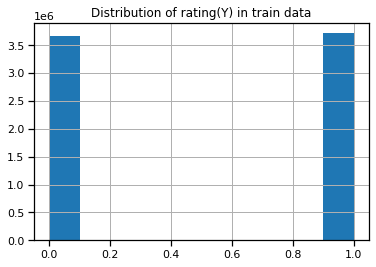

In [17]:
fig, ax = plt.subplots()
train_df["rating"].hist(ax = ax)
ax.set_title("Distribution of rating(Y) in train data")

**users**

Number of samples of users ranges from 1 to more than 1000. The mode is 1, and distribution decreases as the number of samples increases. 
It shows that there are lots of users that cannot rely on collaborative approach only. 

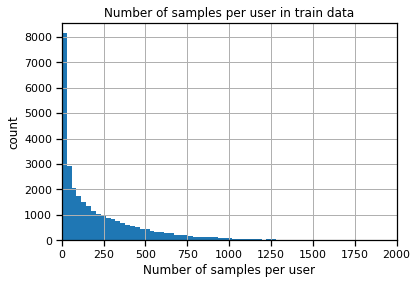

In [18]:
fig, ax = plt.subplots()
train_df[["userID", "rating"]].groupby("userID").count().hist(bins = 200, ax = ax)
ax.set_xlim(0, 2000)
ax.set_ylabel("count")
ax.set_xlabel("Number of samples per user")
ax.set_title("Number of samples per user in train data")
plt.show()

**items**

There are so many songs which has only one sample in train data. It makes histogram (left) harder to see, Histogram in Log scale (right one) shows that there are songs which have more than 10,000 samples. 

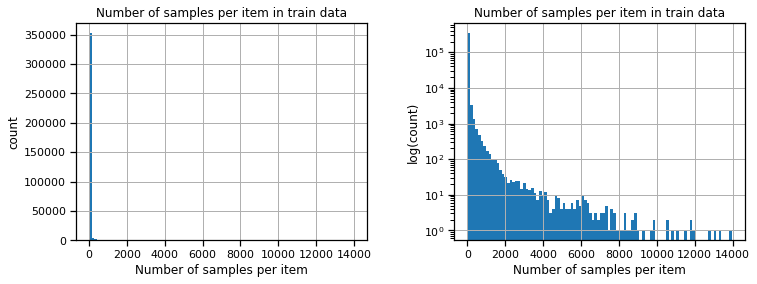

In [19]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
train_df[["itemID", "rating"]].groupby("itemID").count().hist(bins = 100, ax = ax[1])
train_df[["itemID", "rating"]].groupby("itemID").count().hist(bins = 100, ax = ax[0])
ax[1].set_yscale("log")
ax[1].set_ylabel("log(count)")
ax[0].set_ylabel("count")
for i in range(2):
    ax[i].set_xlabel("Number of samples per item")
    ax[i].set_title("Number of samples per item in train data")
plt.show()

### 4.2 Grouping "source_system_tab" to "source_id"

`source_system_tab` is the most important basic feature, because there are significant difference of mean rating between sources. For example, `my library` has highest mean rating. Of course it is highest, because a song is added to library by a user. In contrast, `radio` is lowest in mean rating. It is also plausible because radio plays songs randomly, and user tends to forget its name. Furthermore, `discover`, `explore`, `search` would mean the same thing where user actively search songs. 

Text(0.5, 1.0, 'Histogram')

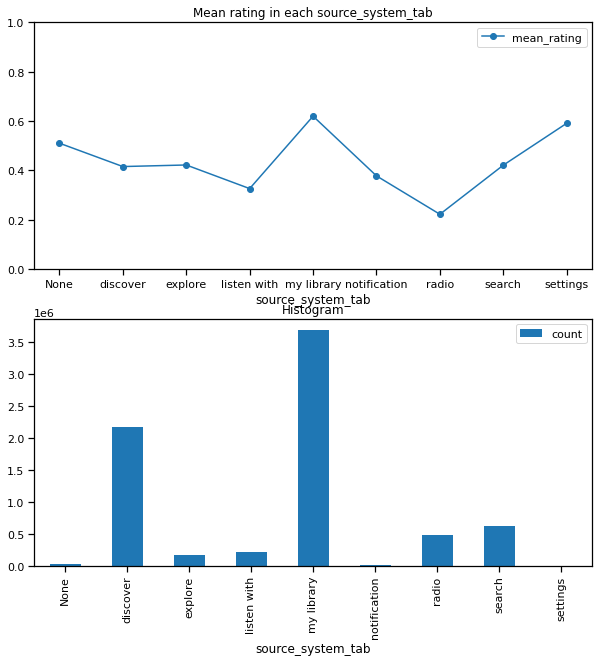

In [20]:
fig, ax = plt.subplots(2, figsize = (10, 10))
train_df[["source_system_tab", "rating"]].groupby("source_system_tab").mean().rename({"rating":"mean_rating"}, axis = 1).plot(ax=ax[0], marker = "o")
#ax.axhline(y = train_df["rating"].mean(), ls = "-.", color = "red", label = "global mean")
ax[0].set_ylim(0,1)
ax[0].legend()
ax[0].set_title("Mean rating in each source_system_tab")

train_df[["source_system_tab", "rating"]].groupby("source_system_tab").count().rename({"rating":"count"}, axis = 1).plot.bar(ax=ax[1])
ax[1].set_title("Histogram")

**Gouping source and convert to integer**

Based on mean rating and interpretation, similar values are grouped, and converted into integer.

In [21]:
g0_set = set(["my library", "settings"])
g1_set = set(["discover", "explore", "search"])
g2_set = set(["listen with", "notification"])
g3_set = set(["radio"])

def source_id(source):
    
    if source in g0_set:
        return 0
    
    if source in g1_set:
        return 1
    
    if source in g2_set:
        return 2
    
    if source in g3_set:
        return 3
    
    return 4
    

In [22]:
train_df["source_id"] = train_df["source_system_tab"].apply(lambda x: source_id(x))
test_df["source_id"] = test_df["source_system_tab"].apply(lambda x: source_id(x))

### 4.3 Time Series Feature: Time since the first play

Raing of music must be sentitive in time. People get tired of popular songs after a while. Thus, mean rating should be decayed in time.
Although there is no information about time in data, I assumed that index is allocated in time order. I created new feature `time_firstplay` which means the time when the song firstly played in the data. Then for all the songs in the data, `time_since_firstplay` is calculated. It is divided by $5.0 * 10^5$, because value is too large. 

In [23]:
train_df["time"] = np.arange(n_train)
test_df["time"] = np.arange(n_train, n_train + n_test)

In [24]:
time_first_df = pd.concat([train_df[["itemID", "time"]], test_df[["itemID", "time"]]]).groupby("itemID").min().reset_index().rename({"time":"time_firstplay"}, axis = 1)

In [25]:
train_df = train_df.merge(time_first_df, on = "itemID", how = "left")
test_df = test_df.merge(time_first_df, on = "itemID", how = "left")
train_df["time_since_firstplay"] = (train_df["time"] - train_df["time_firstplay"])//(10**5*5)
test_df["time_since_firstplay"] = (test_df["time"] - test_df["time_firstplay"])//(10**5*5)

### 4.4 Song minutes

`song_length` apparently shows the length of song in milliseconds scale. It is more convenient to convert it into minutes.


In [26]:
song_df["song_minute"] = np.round(song_df["song_length"]/(10**3*60))

In [27]:
song_df[["song_length", "song_minute"]].head()

,song_length,song_minute
0,247640,4.0
1,197328,3.0
2,231781,4.0
3,273554,5.0
4,140329,2.0


### 4.5 Artists' mean rating

To add feature attributed to artist and song minute, `artist_id` and `song_minute` is merged to train and test data from the song list.

In [28]:
train_df = train_df.merge(song_df[["itemID", "artist_id", "song_minute"]], on = "itemID", how = "left")
test_df = test_df.merge(song_df[["itemID", "artist_id", "song_minute"]], on = "itemID", how = "left")

In [29]:
# fill NaN with -1
filter1 = train_df["artist_id"].isna()
train_df.loc[filter1, "artist_id"] = -1
train_df["artist_id"] = train_df["artist_id"].astype(int)

filter1 = test_df["artist_id"].isna()
test_df.loc[filter1, "artist_id"] = -1
test_df["artist_id"] = test_df["artist_id"].astype(int)

### 4.6 Visualizing features

`feature_prob` function calculate mean rating of each value in labels (specified columns). It exclude validations data, and data with small number of counts (< min_count) are removed. It returns dictionary for prediction and dataframe for visualization.

In [30]:
def feature_prob(labels, n_val, min_count):
        
    n_train = train_df.shape[0]
    
    # to exclude validation data from feature
    n_train2 = n_train - n_val
    
    select =  labels + ["rating"]
    sum_df=train_df[select].iloc[:n_train2,:].groupby(labels).sum()
    count_df=train_df[select].iloc[:n_train2,:].groupby(labels).count()
    
    # small count is removed from 
    p_df = (sum_df/count_df)
    filter1 = count_df["rating"] > min_count
        
    p_df = p_df.loc[filter1,:].reset_index()

    key_array = p_df[labels].to_numpy()
    val_array = p_df["rating"].to_numpy()
    
    p_dic = {}
    for i in range(key_array.shape[0]):
        #print(key_array[i])
        p_dic[tuple(key_array[i])] = val_array[i]
    
    return p_dic,p_df

#### Validation Size

Validation data is the latter 20% of train data. It means that the validation data is newer than train data.  Sklearn's train_test_split is NOT used because train and validation shall not be shuffled.

In [31]:
n_val = int(0.2*n_train)

**Features**

Mean rating by `source_id` is called **global mean** in this report. Mean rating of `artist_id`, `song_minute`, `time_since_firstplay`, `itemID`, `userID` are calculated by each `source_id`. They are used for content-based approach.

In [32]:
p_source_dic, p_source_df = feature_prob(["source_id"], n_val, 0)
p_artist_dic, p_artist_df = feature_prob(["artist_id", "source_id"], n_val, 20)
p_songmin_dic, p_songmin_df = feature_prob(["song_minute", "source_id"], n_val, 20)
p_songage_dic, p_songage_df = feature_prob(["time_since_firstplay", "source_id"], n_val, 20)
p_song_dic, p_song_df = feature_prob(["itemID", "source_id"], n_val, 20)
p_user_dic, p_user_df = feature_prob(["userID", "source_id"], n_val, 20)

### Merge feature to train data

In [33]:
train_df["global_mean"] = train_df[["source_id"]].merge(p_source_df, on = ["source_id"], how = "left")["rating"].to_numpy()

In [34]:
train_df["artist_bias"] = train_df[["artist_id", "source_id"]].merge(p_artist_df, on = ["artist_id", "source_id"], how = "left")["rating"].to_numpy()
filter1 = train_df["artist_bias"].isna()
train_df.loc[filter1,"artist_bias"] = train_df.loc[filter1, "global_mean"]

In [31]:
def merge_feature(df1, name1, test = False):
    
    labels = list(df1.columns[:-1])
    train_df[name1] = train_df[labels].merge(df1, on = labels, how = "left")["rating"].to_numpy()
    
    filter1 =train_df[name1].isna()
    train_df.loc[filter1, name1] = train_df.loc[filter1, "global_mean"]
    
    if test:
        test_df[name1] = test_df[labels].merge(df1, on = labels, how = "left")["rating"].to_numpy()

        filter1 =test_df[name1].isna()
        test_df.loc[filter1, name1] = test_df.loc[filter1, "global_mean"]
    

In [36]:
merge_feature(p_artist_df, "artist_p")
merge_feature(p_songmin_df, "songmin_p")
merge_feature(p_songage_df, "songage_p")
merge_feature(p_song_df, "item_bias")
merge_feature(p_user_df, "user_bias")

## Tuning and Validation

In [41]:
features = ["userID", "itemID", "source_id", "artist_id", "artist_p", "global_mean", "songmin_p", "songage_p", "item_bias", "user_bias"]

In [38]:
X_train = train_df[features].iloc[0:-n_val,:]
y_train = train_df["rating"].iloc[0:-n_val].to_numpy()

X_val = train_df[features].iloc[-n_val:,:]
y_val = train_df["rating"].iloc[-n_val:].to_numpy()

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
def RF_train_and_val(X_train, y_train, X_val, y_val, m_depth, n_trainsample, test = False):
    
    n_train = X_train.shape[0]
    
    np.random.seed(1)
    train_indx = np.random.choice(n_train, n_trainsample)
    
    time1 = time.time()
    
    clf = RandomForestClassifier(max_depth=m_depth, random_state=0, n_estimators = 100)
    clf.fit(X_train.iloc[train_indx,:], y_train[train_indx])
    
    time2 = time.time()
    
    train_time = np.round(time2 - time1)
    
    print("train time[sec]", train_time)
    
    if test:
        return clf
    
    
    #yhat_train = clf.predict_proba(X_train)[:,1]
    
    #fpr, tpr, thresholds = metrics.roc_curve(y_train, yhat_train, pos_label=1)
    #train_auc = metrics.auc(fpr, tpr)
    
    time3 = time.time()

    yhat_val = clf.predict_proba(X_val)[:,1]
    
    time4 = time.time()
    
    val_time = np.round(time4 - time3)
    
    print("prdiction time for validation", val_time)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_val, yhat_val, pos_label=1)
    val_auc = metrics.auc(fpr, tpr)
    
    
    print("val auc",val_auc)
    
    return val_auc
    

In [42]:
m_depths = [7, 8,9,10, 11]
scores = []
for m_depth in m_depths:
    print("max depth", m_depth)
    score = RF_train_and_val(X_train, y_train, X_val, y_val, m_depth = m_depth, n_trainsample = 100000)   
    scores.append(score)

max depth 7
train time[sec] 12.0
prdiction time for validation 14.0
val auc 0.6603725496457302
max depth 8
train time[sec] 14.0
prdiction time for validation 16.0
val auc 0.6607745036791972
max depth 9
train time[sec] 15.0
prdiction time for validation 20.0
val auc 0.6605101191738653
max depth 10
train time[sec] 17.0
prdiction time for validation 20.0
val auc 0.6604941690257887
max depth 11
train time[sec] 19.0
prdiction time for validation 22.0
val auc 0.6599606920021885


Text(0, 0.5, 'auc')

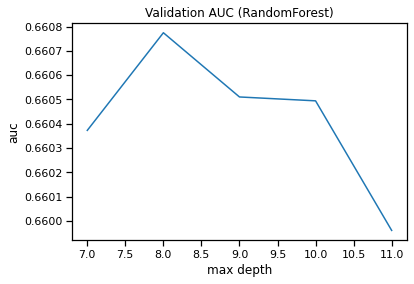

In [43]:
fig, ax = plt.subplots()
ax.plot(m_depths, scores)
ax.set_title("Validation AUC (RandomForest)")
ax.set_xlabel("max depth")
ax.set_ylabel("auc")

**best max depth = 8**

## Test

In [34]:
n_val = 0

In [35]:
p_source_dic, p_source_df = feature_prob(["source_id"], n_val, 0)
p_artist_dic, p_artist_df = feature_prob(["artist_id", "source_id"], n_val, 20)
p_songmin_dic, p_songmin_df = feature_prob(["song_minute", "source_id"], n_val, 20)
p_songage_dic, p_songage_df = feature_prob(["time_since_firstplay", "source_id"], n_val, 20)
p_song_dic, p_song_df = feature_prob(["itemID", "source_id"], n_val, 20)
p_user_dic, p_user_df = feature_prob(["userID", "source_id"], n_val, 20)

In [36]:
train_df["global_mean"] = train_df[["source_id"]].merge(p_source_df, on = ["source_id"], how = "left")["rating"].to_numpy()

In [37]:
test_df["global_mean"] = test_df[["source_id"]].merge(p_source_df, on = ["source_id"], how = "left")["rating"].to_numpy()

In [38]:
max_v = train_df["time_since_firstplay"].max()
filter1 = test_df["time_since_firstplay"] > max_v
test_df.loc[filter1, "time_since_firstplay"] = max_v

In [39]:
merge_feature(p_artist_df, "artist_p", True)
merge_feature(p_songmin_df, "songmin_p", True)
merge_feature(p_songage_df, "songage_p", True)
merge_feature(p_song_df, "item_bias", True)
merge_feature(p_user_df, "user_bias", True)

In [42]:
X_train = train_df[features]
y_train = train_df["rating"].to_numpy()

X_test = test_df[features]

In [43]:
clf = RF_train_and_val(X_train, y_train, X_val = None, y_val = None, m_depth = 8, n_trainsample = 300000, test = True)   

train time[sec] 43.0


In [44]:
yhat_test = clf.predict_proba(X_test)[:,1]

In [45]:
sample_df = pd.read_parquet("data/sample_submission.parquet")
sample_df["target"] = yhat_test
sample_df.to_csv("output/RF_depth8.csv", index = False)

**kaggle private score: 0.65998**